In [1]:
import pyzed.sl as sl
import math
import numpy as np
import sys
import cv2
import matplotlib.pyplot as plt

In [38]:
# Create a ZED camera object
zed = sl.Camera()

# Set configuration parameters
init_params = sl.InitParameters()
init_params.camera_resolution = sl.RESOLUTION.HD1080 
init_params.camera_fps = 1 

In [39]:
#open camera
err = zed.open(init_params)
if (err != sl.ERROR_CODE.SUCCESS) :
    exit(-1)

In [40]:
# Get camera information (serial number)
zed_serial = zed.get_camera_information().serial_number
print("Hello! This is my serial number: ", zed_serial)

Hello! This is my serial number:  31317922


In [41]:
# Capture 50 frames and stop
i = 0
image = sl.Mat()
while (i < 10) :
    # Grab an image
    if (zed.grab() == sl.ERROR_CODE.SUCCESS) :
        # A new image is available if grab() returns SUCCESS
        zed.retrieve_image(image, sl.VIEW.LEFT) # Get the left image
        timestamp = zed.get_timestamp(sl.TIME_REFERENCE.IMAGE) # Get the timestamp at the time the image was captured
        print("Image resolution: ", image.get_width(), " x ", image.get_height()," || Image timestamp: ", timestamp.get_milliseconds())
        i = i+1

Image resolution:  1920  x  1080  || Image timestamp:  1692030807977
Image resolution:  1920  x  1080  || Image timestamp:  1692030808044
Image resolution:  1920  x  1080  || Image timestamp:  1692030808178
Image resolution:  1920  x  1080  || Image timestamp:  1692030808245
Image resolution:  1920  x  1080  || Image timestamp:  1692030808312
Image resolution:  1920  x  1080  || Image timestamp:  1692030808379
Image resolution:  1920  x  1080  || Image timestamp:  1692030808446
Image resolution:  1920  x  1080  || Image timestamp:  1692030808513
Image resolution:  1920  x  1080  || Image timestamp:  1692030808580
Image resolution:  1920  x  1080  || Image timestamp:  1692030808647


In [16]:
# Capture 50 images and depth, then stop
i = 0
image = sl.Mat()
depth = sl.Mat()
while (i < 50) :
    # Grab an image
    if (zed.grab() == sl.ERROR_CODE.SUCCESS) :
        # A new image is available if grab() returns SUCCESS
        zed.retrieve_image(image, sl.VIEW.LEFT) # Get the left image
        zed.retrieve_measure(depth, sl.MEASURE.DEPTH) # Retrieve depth Mat. Depth is aligned on the left image
        i = i + 1

In [15]:
def main():
    # Create a Camera object
    zed = sl.Camera()

    # Create a InitParameters object and set configuration parameters
    init_params = sl.InitParameters()
    init_params.depth_mode = sl.DEPTH_MODE.ULTRA  # Use PERFORMANCE depth mode
    init_params.coordinate_units = sl.UNIT.METER  # Use meter units (for depth measurements)
    init_params.camera_resolution = sl.RESOLUTION.HD2K

    # Open the camera
    err = zed.open(init_params)
    if err != sl.ERROR_CODE.SUCCESS:
        exit(1)

    # Create and set RuntimeParameters after opening the camera
    runtime_parameters = sl.RuntimeParameters()
    runtime_parameters.confidence_threshold = 100
    runtime_parameters.texture_confidence_threshold = 100

    # Capture 150 images and depth, then stop
    i = 0
    image = sl.Mat()
    image2 = sl.Mat()
    depth = sl.Mat()
    depth2 = sl.Mat()
    point_cloud = sl.Mat()
    depthlist=[]

    mirror_ref = sl.Transform()
    mirror_ref.set_translation(sl.Translation(2.75,4.0,0))
    tr_np = mirror_ref.m
    #print('setting')
    while i < 10:
        # A new image is available if grab() returns SUCCESS
        if (zed.grab() == sl.ERROR_CODE.SUCCESS):
            # Retrieve left image
            zed.retrieve_image(image, sl.VIEW.LEFT)
            image.write(f'output/img/image_{i:02}imgL.jpg')
            zed.retrieve_image(image2, sl.VIEW.RIGHT)
            image2.write(f'output/img/image_{i:02}imgR.jpg')

            # Retrieve depth map. Depth is aligned on the left image
            zed.retrieve_measure(depth2, sl.MEASURE.DEPTH)
            zed.retrieve_image(depth, sl.VIEW.DEPTH)#this give an image for displaying
            depth.write(f'output/depth/depth_{i:02}img.jpg')
            depth2.write(f'output/depth/depth2_{i:02}img.png')
            depthlist.append((depth2.numpy()).copy())
            # Retrieve colored point cloud. Point cloud is aligned on the left image.
            zed.retrieve_measure(point_cloud, sl.MEASURE.XYZRGBA)
            point_cloud.write(f'output/pcd/pc_{i:02}img.pcd')
            i = i + 1

            # Get and print distance value in mm at the center of the image
            # We measure the distance camera - object using Euclidean distance
            #x = round(image.get_width() / 2)
            #y = round(image.get_height() / 2)
            #err, point_cloud_value = point_cloud.get_value(x, y)

            #distance = math.sqrt(point_cloud_value[0] * point_cloud_value[0] +
            #                     point_cloud_value[1] * point_cloud_value[1] +
            #                     point_cloud_value[2] * point_cloud_value[2])

            #point_cloud_np = point_cloud.get_data()
            #point_cloud_np.dot(tr_np)

            #if not np.isnan(distance) and not np.isinf(distance):
            #    print("Distance to Camera at ({}, {}) (image center): {:1.3} m".format(x, y, distance), end="\r")
            #    # Increment the loop
            #    i = i + 1
            #else:
            #    print("Can't estimate distance at this position.")
            #    print("Your camera is probably too close to the scene, please move it backwards.\n")
            #sys.stdout.flush()

    # Close the camera
    zed.close()
    return depthlist


In [16]:

if __name__ == "__main__":
    depthlist=main()

In [41]:
np.nanmax(np.dstack(depthlist))

inf

In [29]:
type(np.NAN)

float

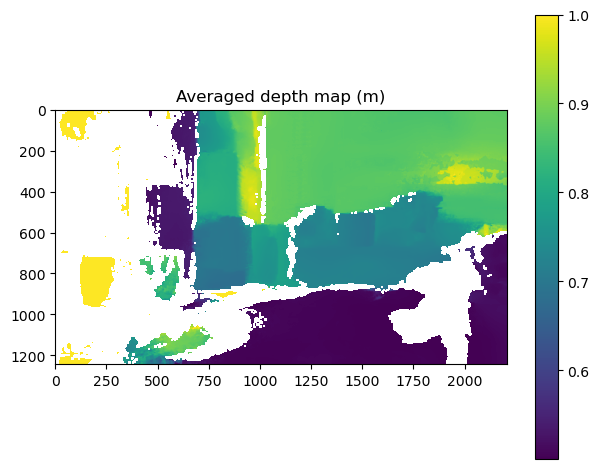

In [55]:
avg=np.ma.masked_invalid(np.dstack(depthlist))
plt.imshow(np.mean(avg,axis=2), vmax=1)
plt.colorbar()
plt.title('Averaged depth map (m)')
plt.tight_layout()

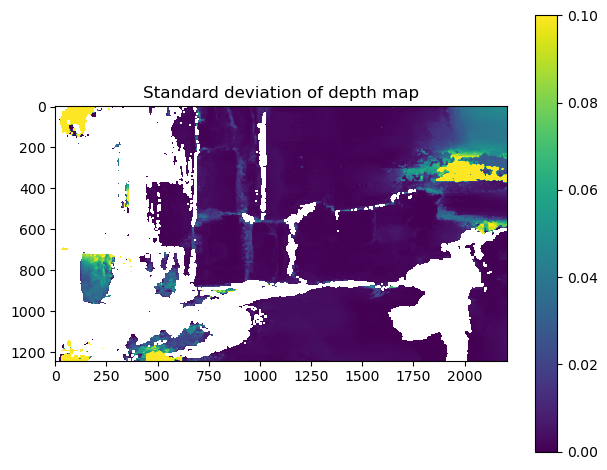

In [61]:
avg=np.ma.masked_invalid(np.dstack(depthlist))
plt.imshow(np.std(avg,axis=2), vmax=0.1)
plt.colorbar()
plt.title('Standard deviation of depth map')
plt.tight_layout()

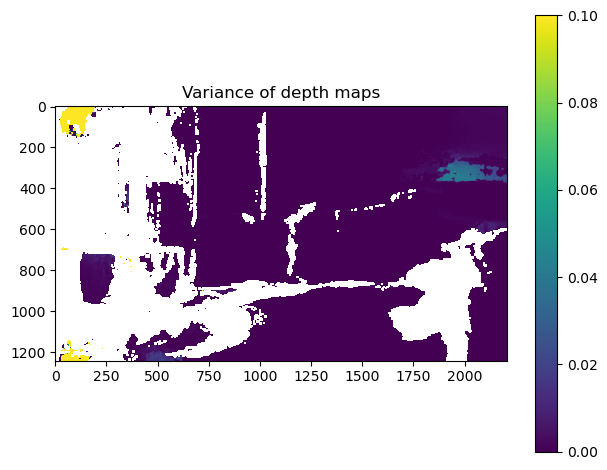

In [116]:
avg=np.ma.masked_invalid(np.dstack(depthlist))
plt.imshow(np.var(avg,axis=2), vmax=0.1)
plt.colorbar()
plt.title('Variance of depth maps')
plt.tight_layout()

c:\Users\vitoc\miniconda3\envs\stereo\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\vitoc\AppData\Local\Temp\ipykernel_22140\3595231717.py:1: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(np.dstack(depthlist),axis=2))


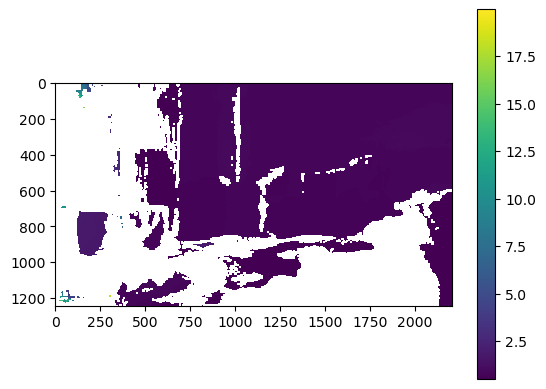

In [34]:
plt.imshow(np.nanmean(np.dstack(depthlist),axis=2))
plt.colorbar()

In [3]:
zed.close()

NameError: name 'zed' is not defined

In [14]:
np.mean(np.dstack((np.ones((6,2)), np.zeros((6,2)),np.ones((6,2)))),axis=2)

array([[0.66666667, 0.66666667],
       [0.66666667, 0.66666667],
       [0.66666667, 0.66666667],
       [0.66666667, 0.66666667],
       [0.66666667, 0.66666667],
       [0.66666667, 0.66666667]])

In [24]:
depth2

n/a Ts 1692113585323316800 sl::Mat of size [1280,720], with 1 channels of type float allocated on CPU (memory owned).

In [25]:
depth2.get_width(), depth2.get_height()

(1280, 720)

In [40]:
depth2.get_value(1279,78)[1]

0.8691677451133728

In [42]:
ar_depth=np.zeros((1279,719))
ar_depth

(1279, 78)

In [52]:
ar_depth=depth2.numpy()
ar_depth

array([[       nan,        nan,        nan, ..., 0.86732435, 0.86734504,
        0.8672985 ],
       [       nan,        nan,        nan, ..., 0.8673275 , 0.8672968 ,
        0.86726344],
       [       nan,        nan,        nan, ..., 0.86733633, 0.8672505 ,
        0.8672298 ],
       ...,
       [       inf,        inf,        inf, ...,       -inf,       -inf,
              -inf],
       [       inf,        inf,        inf, ...,       -inf,       -inf,
              -inf],
       [       inf,        inf,        inf, ...,       -inf,       -inf,
              -inf]], dtype=float32)

In [54]:
mask=depth2.numpy()==depth2.get_data()

In [57]:
np.unique(depth2.get_data()[mask==False])

array([nan], dtype=float32)

In [ ]:
# Get the 3D point cloud values for pixel (i, j)
point3D = point_cloud.get_value(i, j)
x = point3D[0]
y = point3D[1]
z = point3D[2]
color = point3D[3]

In [4]:
def main():
    # Create a ZEDCamera object
    zed = sl.Camera()

    # Create a InitParameters object and set configuration parameters
    init_params = sl.InitParameters()
    init_params.camera_resolution = sl.RESOLUTION.HD720  # Use HD720 video mode (default fps: 60)
    # Use a right-handed Y-up coordinate system
    init_params.coordinate_system = sl.COORDINATE_SYSTEM.RIGHT_HANDED_Y_UP
    init_params.coordinate_units = sl.UNIT.METER  # Set units in meters

    # Open the camera
    err = zed.open(init_params)
    if err != sl.ERROR_CODE.SUCCESS:
        exit(1)

    # Enable positional tracking with default parameters.
    # Positional tracking needs to be enabled before using spatial mapping
    py_transform = sl.Transform()
    tracking_parameters = sl.PositionalTrackingParameters(_init_pos=py_transform)
    err = zed.enable_positional_tracking(tracking_parameters)
    if err != sl.ERROR_CODE.SUCCESS:
        exit(1)

    # Enable spatial mapping
    mapping_parameters = sl.SpatialMappingParameters(map_type=sl.SPATIAL_MAP_TYPE.FUSED_POINT_CLOUD)
    err = zed.enable_spatial_mapping(mapping_parameters)
    if err != sl.ERROR_CODE.SUCCESS:
        exit(1)

    # Grab data during 3000 frames
    i = 0
    py_fpc = sl.FusedPointCloud()  # Create a Mesh object
    runtime_parameters = sl.RuntimeParameters()

    while i < 3000:
        # For each new grab, mesh data is updated
        if zed.grab(runtime_parameters) == sl.ERROR_CODE.SUCCESS:
            # In the background, spatial mapping will use newly retrieved images, depth and pose to update the mesh
            mapping_state = zed.get_spatial_mapping_state()

            print("\rImages captured: {0} / 3000 || {1}".format(i, mapping_state))

            i = i + 1

    print("\n")

    # Extract, filter and save the mesh in an obj file
    print("Extracting Point Cloud...\n")
    err = zed.extract_whole_spatial_map(py_fpc)
    print(repr(err))
    #print("Filtering Mesh...\n")
    #py_mesh.filter(sl.MeshFilterParameters())  # Filter the mesh (remove unnecessary vertices and faces)
    print("Saving Point Cloud...\n")
    py_fpc.save("fpc.obj")

    # Disable tracking and mapping and close the camera
    zed.disable_spatial_mapping()
    zed.disable_positional_tracking()
    zed.close()

if __name__ == "__main__":
    main()

Images captured: 0 / 3000 || SPATIAL_MAPPING_STATE.INITIALIZING
Images captured: 1 / 3000 || SPATIAL_MAPPING_STATE.INITIALIZING
Images captured: 2 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 3 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 4 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 5 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 6 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 7 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 8 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 9 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 10 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 11 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 12 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 13 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 14 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 15 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 16 / 3000 || SPATIAL_MAPPING_STATE.OK
Images captured: 17 / 3000 || SPATIAL_MAPPING_STATE.OK


In [62]:
# Close the camera
zed.close()

In [65]:
img = cv2.imread('output/depth/depth_00img.jpg', cv2.IMREAD_UNCHANGED)
# Remove infinite value to display
#img[img==None] = 0

# Normalize and convert to uint8
#img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)#.astype(np.uint8)

# Show
cv2.imshow("img", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [94]:
zed = sl.Camera()
#Create a InitParameters object and set configuration parameters
init_params = sl.InitParameters()
init_params.depth_mode = sl.DEPTH_MODE.ULTRA  # Use PERFORMANCE depth mode
init_params.coordinate_units = sl.UNIT.METER  # Use meter units (for depth measurements)
init_params.camera_resolution = sl.RESOLUTION.HD2K

# Open the camera
err = zed.open(init_params)
if err != sl.ERROR_CODE.SUCCESS:
    exit(1)

calibration_params = zed.get_camera_information().camera_configuration.calibration_parameters
# Focal length of the left eye in pixels
f = calibration_params.left_cam.focal_length_metric
fx = calibration_params.left_cam.fx
# First radial distortion coefficient
#k1 = calibration_params.left_cam.disto[0]
# Translation between left and right eye on z-axis
tx = calibration_params.stereo_transform
# Horizontal field of view of the left eye in degrees
#h_fov = calibration_params.left_cam.h_fov
# principal points
cx = calibration_params.left_cam.cx
cy = calibration_params.left_cam.cy
cxr = calibration_params.right_cam.cx
B = calibration_params.get_camera_baseline()

zed.close()

In [96]:
fx

1911.7869873046875

In [107]:
B

0.11993091553449631

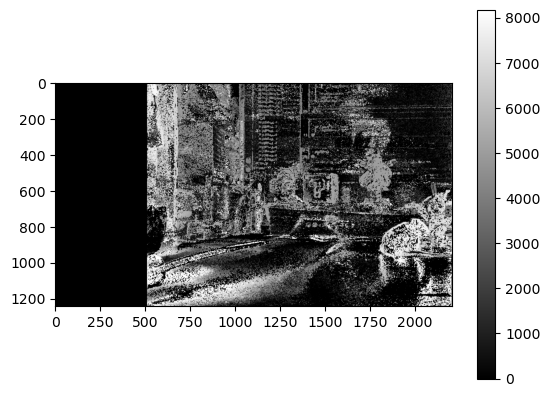

In [100]:
#RECTIFIED version
imgL = cv2.imread('output/img/image_00imgL.jpg', cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread('output/img/image_00imgR.jpg', cv2.IMREAD_GRAYSCALE)
stereo = cv2.StereoSGBM_create(numDisparities=512, blockSize=5)
#num is search range of disparity
#blocksize is window size, must be odd
disparity = stereo.compute(imgL,imgR)
plt.imshow(disparity,'gray')
plt.colorbar()
plt.show()

C:\Users\vitoc\AppData\Local\Temp\ipykernel_22140\2641196849.py:4: RuntimeWarning: divide by zero encountered in divide
  dp = ((B*1000*f)/disp)/1000


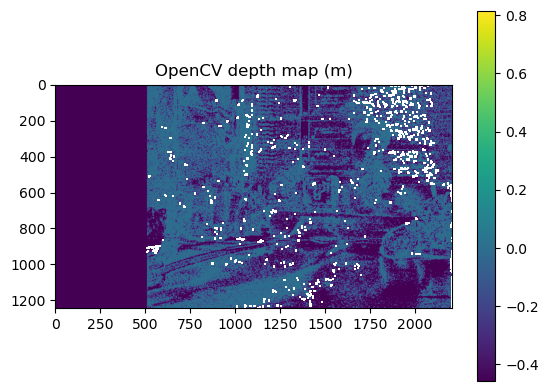

In [113]:
# print('computing disparity...')
disp = disparity.astype(np.float32) / 16.0

dp = ((B*1000*f)/disp)/1000
plt.imshow(dp)#, vmax=1, vmin=0)
plt.colorbar()
plt.title('OpenCV depth map (m)');

In [84]:
# print('computing disparity...')
disp = disparity.astype(np.float32) / 16.0

# print('generating 3d point cloud...',)
h, w = imgL.shape[:2]
f = 0.8 * w  # guess for focal length
Q = np.float32([[1, 0, 0, -cx],
                [0, 1, 0, -cy],  # turn points 180 deg around x-axis,
                [0, 0, 0, f/1000],  # so that y-axis looks up
                [0, 0, -1/B, (cx-cxr)/B]])
points = cv2.reprojectImageTo3D(disp, Q)
colors = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)

In [85]:
def create_output(vertices, colors, filename):
	colors = colors.reshape(-1,3)
	vertices = np.hstack([vertices.reshape(-1,3),colors])

	ply_header = '''ply
		format ascii 1.0
		element vertex %(vert_num)d
		property float x
		property float y
		property float z
		property uchar red
		property uchar green
		property uchar blue
		end_header
		'''
	with open(filename, 'w') as f:
		f.write(ply_header %dict(vert_num=len(vertices)))
		np.savetxt(f,vertices,'%f %f %f %d %d %d')
create_output(points, colors, 'cvpc.ply')

In [72]:
np.hstack([points.reshape(-1,3),colors.reshape(-1,3)])

array([[-1.3517561e+02, -7.7386284e+01,  4.5763238e-04,  8.0000000e+00,
         8.0000000e+00,  8.0000000e+00],
       [-1.3505568e+02, -7.7386284e+01,  4.5763238e-04,  9.0000000e+00,
         9.0000000e+00,  9.0000000e+00],
       [-1.3493575e+02, -7.7386284e+01,  4.5763238e-04,  1.0000000e+01,
         1.0000000e+01,  1.0000000e+01],
       ...,
       [           inf,            inf,            inf,  1.9900000e+02,
         1.9900000e+02,  1.9900000e+02],
       [           inf,            inf,            inf,  1.9800000e+02,
         1.9800000e+02,  1.9800000e+02],
       [           inf,            inf,            inf,  2.0000000e+02,
         2.0000000e+02,  2.0000000e+02]], dtype=float32)